In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Fixing format of the label
def enc_label(label):
    code = 0
    if label == "right-turn":
        code = 1
    if label == "side":
        code = 2
    if label == "cuban-basic":
        code = 3
    if label == "suzie-q":
        code = 4
    return code

In [3]:
# Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 40   # number of frames per figure
NUM_FEATURES = 75     # number of join coordinates
no_sample = 20        # number of examples

In [4]:
# Import the data
PATH_DATA_TRAIN = "Data_train_validate/Data_train.csv"
PATH_DATA_VAL = "Data_train_validate/Data_val.csv"

data_train = pd.read_csv(PATH_DATA_TRAIN)
data_val = pd.read_csv(PATH_DATA_VAL)

In [5]:
data_train.head()

,Unnamed: 0,clip_name,frame_nr,person_id,nose_x,nose_y,neck_x,neck_y,rshoulder_x,rshoulder_y,...,lear_v,lbigtoe_v,lsmalltoe_v,lheal_v,rbigtoe_v,rsmalltoe_v,rheal_v,label,status,figure_id
0,0,1p_Artur_05122021_chreo1,3076,0.0,371.914,208.838,286.625,284.035,254.053,284.106,...,0.0,0.167004,0.000000,0.292184,0.161746,0.205243,0.409271,basic,S,31
1,1,1p_Artur_05122021_chreo1,3077,0.0,371.997,208.804,289.104,286.531,256.487,286.589,...,0.0,0.830399,0.735115,0.638986,0.445242,0.485568,0.512514,basic,NaN,31
2,2,1p_Artur_05122021_chreo1,3078,0.0,372.040,208.807,289.089,289.018,256.514,289.133,...,0.0,0.830398,0.723441,0.644061,0.078744,0.000000,0.137077,basic,NaN,31
3,3,1p_Artur_05122021_chreo1,3079,0.0,372.016,208.677,286.565,286.543,256.496,289.136,...,0.0,0.713264,0.632407,0.521834,0.263503,0.229858,0.310501,basic,NaN,31
4,4,1p_Artur_05122021_chreo1,3080,0.0,374.424,206.255,284.079,276.587,254.055,279.072,...,0.0,0.400066,0.372775,0.343811,0.607639,0.554454,0.501505,basic,NaN,31


In [17]:
# Function to select a number of frames per figure and right in the correct format for the mdoel

def transf_data(data):
    # Data preprocessing, get the input X and the label y
    ind_start = data[data['status'] == "S"].index.tolist()
    ind_end = data[data['status'] == "E"].index.tolist()
    
    # Take intervals between consecutive "S", they define one figure
    X = []
    y = []

    for i in range(len(ind_start) - 1):
        X.append(data.iloc[ind_start[i]: ind_end[i], 4:-3])  # the last 25 (visibility ) + 2
        y.append(data.loc[ind_start[i], 'label'])
    
    # select frames from the interval
    ind_samp = []

    for i in range(len(ind_start) - 1):
        # Take frames that are evenlly distributed
        aux = np.linspace(ind_start[i]
                      , ind_end[i]
                      , MAX_SEQ_LENGTH
                      , endpoint=False).astype(int)

        # random
        # aux = np.random.randint(ind_start[i], ind_end[i], MAX_SEQ_LENGTH)
        # aux.sort()
        ind_samp.append(aux)


    # Changing format of the data to be compatible with Tensor Flow
    X = [x.loc[ind_samp[ind], :].to_numpy() for (ind, x) in enumerate(X)]
    X = np.array(X)
    X = X.reshape(len(ind_start) - 1, MAX_SEQ_LENGTH, NUM_FEATURES).astype("float32")
    # TODO: decide of the X values need to be normalized
    y = [enc_label(x) for x in y]
    y = np.array(y).astype("float32")     
    
    return X, y

In [19]:
X_train, y_train = transf_data(data_train) 
X_val, y_val = transf_data(data_val) 

In [20]:
# Build the model
# TODO: use functional way to build the model
# eg: https://keras.io/examples/vision/video_classification/ (The sequence model)
model = models.Sequential()
model.add(layers.Flatten(input_shape=(MAX_SEQ_LENGTH, NUM_FEATURES)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(5, activation="softmax"))
model.summary()

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 128)               384128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 392,709
Trainable params: 392,709
Non-trainable params: 0
_________________________________________________________________


2021-12-12 22:21:56.360918: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Check the trainning accuracy
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=5,
    validation_data=(X_val, y_val)
)

Epoch 1/100
77/77 [==============================] - 1s 7ms/step - loss: 310.1492 - accuracy: 0.2344 - val_loss: 139.2084 - val_accuracy: 0.2128
Epoch 2/100
77/77 [==============================] - 0s 5ms/step - loss: 53.2949 - accuracy: 0.2682 - val_loss: 39.7050 - val_accuracy: 0.2234
Epoch 3/100
77/77 [==============================] - 0s 5ms/step - loss: 40.6956 - accuracy: 0.2865 - val_loss: 22.7006 - val_accuracy: 0.3298
Epoch 4/100
77/77 [==============================] - 1s 7ms/step - loss: 21.6597 - accuracy: 0.3099 - val_loss: 18.8596 - val_accuracy: 0.3511
Epoch 5/100
77/77 [==============================] - 0s 5ms/step - loss: 14.0966 - accuracy: 0.3620 - val_loss: 21.8647 - val_accuracy: 0.3191
Epoch 6/100
77/77 [==============================] - 0s 6ms/step - loss: 18.3295 - accuracy: 0.3307 - val_loss: 13.3638 - val_accuracy: 0.2979
Epoch 7/100
77/77 [==============================] - 0s 5ms/step - loss: 8.5657 - accuracy: 0.4036 - val_loss: 4.9702 - val_accuracy: 0.3830

77/77 [==============================] - 0s 6ms/step - loss: 1.6015 - accuracy: 0.1719 - val_loss: 1.7996 - val_accuracy: 0.1915
Epoch 59/100
77/77 [==============================] - 0s 4ms/step - loss: 1.6014 - accuracy: 0.1927 - val_loss: 1.7995 - val_accuracy: 0.2128
Epoch 60/100
77/77 [==============================] - 0s 5ms/step - loss: 1.6015 - accuracy: 0.1667 - val_loss: 1.7995 - val_accuracy: 0.2128
Epoch 61/100
77/77 [==============================] - 1s 10ms/step - loss: 1.6013 - accuracy: 0.1797 - val_loss: 1.7996 - val_accuracy: 0.2128
Epoch 62/100
77/77 [==============================] - 1s 9ms/step - loss: 1.6016 - accuracy: 0.1875 - val_loss: 1.7995 - val_accuracy: 0.2128
Epoch 63/100
77/77 [==============================] - 1s 11ms/step - loss: 1.6015 - accuracy: 0.1979 - val_loss: 1.7995 - val_accuracy: 0.1915
Epoch 64/100
77/77 [==============================] - 1s 7ms/step - loss: 1.6014 - accuracy: 0.1771 - val_loss: 1.7995 - val_accuracy: 0.1915
Epoch 65/100
77/7

In [23]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Train losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Train accuracies")
    plt.show()
    plt.close()

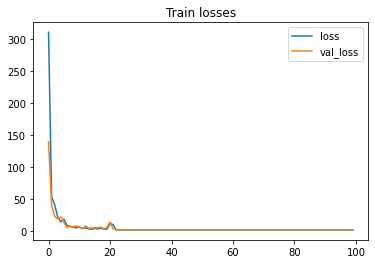

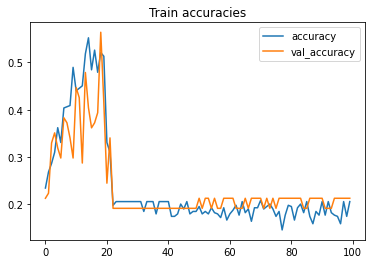

In [24]:
render_history(history.history)